# Linear Regression of housing data

This project will work on housing data for the city of Ames, kowa, US from 2006 to 2010.

The pipeline of functions will be followed as listed:

|train|
|---|
|feature transformation and scaling|
|feature selection|
|train and test|

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('AmesHousing.txt',sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

## features transformation and selection

-  drop columns contain over 5% missing values
-  drop columns leak the sale price
-  transform features to proper format(numerical / catergorical/ scalling...)
-  feature engineering: create new features by combing other features


1.drop missing values

In [5]:
# filter columns contain over 5% missing values

missing_value = df.isnull().sum()
drop_colums = missing_value[missing_value > len(df)*0.05].index
df = df.drop(drop_colums, axis=1)

In [6]:
# drop 'object' columns with 1 or more missing values

null_text_columns = df.select_dtypes(include=['object']).isnull().sum()
text_columns_drop = null_text_columns[null_text_columns > 0].index
df = df.drop(text_columns_drop, axis=1)

In [7]:
# fill numeric missing values with the mean values
num_columns = df.select_dtypes(include=['float', 'int']).isnull().sum()
num_null_index = num_columns[num_columns > 0].index
# compute the most common values to fill the missing vaues

fill_values = df[num_null_index].mode().to_dict(orient = 'records')[0]

df = df.fillna(fill_values)
#df.isnull().sum()


2.create new features

In [8]:
years_to_sell = df['Yr Sold'] - df['Year Built']

years_remod = df['Yr Sold'] - df['Year Remod/Add']

# the new columns should contains no negative vlues, if it does, remove

years_to_sell[years_to_sell < 0]

2180   -1
dtype: int64

In [9]:
years_remod[years_remod <0]

# Hence, we should remove these rows

1702   -1
2180   -2
2181   -1
dtype: int64

In [12]:
df['years_to_sell'] = df['Yr Sold'] - df['Year Built']
df['years_until_remod'] = years_remod = df['Yr Sold'] - df['Year Remod/Add']

In [13]:
df = df.drop([1702, 2180, 2181], axis=0)
df = df.drop(columns=['Yr Sold', 'Year Built', 'Year Remod/Add'])

3.Updated the function to transform features

In [3]:
def transform_features(df):
    # drop all columns with over 5% missing values
    all_missing = df.isnull().sum()
    drop_all = all_missing[all_missing > len(df)*0.05]
    df = df.drop(drop_all.index, axis=1)
    
    # drop 'object' columns with one or more missing values
    text_missing = df.select_dtypes(include=['object']).isnull().sum()
    drop_text = text_missing[text_missing > 0]
    df = df.drop(drop_text.index, axis=1)
    
    # fill numeric columns' missing values with most common value
    num_missing = df.select_dtypes(include=['int','float']).isnull().sum()
    num_filling = num_missing[num_missing > 0]
    fill_value = df[num_filling.index].mode().to_dict(orient='records')[0]
    df = df.fillna(fill_value)
    
    #create new features
    df['years_to_sell'] = df['Yr Sold'] - df['Year Built']
    df['years_until_remod'] = years_remod = df['Yr Sold'] - df['Year Remod/Add']  
    df = df.drop([1702, 2180, 2181], axis=0)

    # drop columns aren't useful for machine learning and leak info of final sale
    useless_columns = ["PID", "Order", "Mo Sold", "Sale Condition", 
                       "Sale Type", "Year Built", "Year Remod/Add"]
    df = df.drop(useless_columns, axis=1)
    
    return df



## Feature selection

In [4]:
df = transform_features(df)
df.head(5)

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Yr Sold,SalePrice,years_to_sell,years_until_remod
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,62,0,0,0,0,0,2010,215000,50,50
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,120,0,0,2010,105000,49,49
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,36,0,0,0,0,12500,2010,172000,52,52
3,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,0,0,0,2010,244000,42,42
4,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,34,0,0,0,0,0,2010,189900,13,12


### Numeric features

In [5]:
numeric_columns = df.select_dtypes(include=['int','float'])
numeric_columns.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Yr Sold,SalePrice,years_to_sell,years_until_remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,62,0,0,0,0,0,2010,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,0,0,0,120,0,0,2010,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,36,0,0,0,0,12500,2010,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,...,0,0,0,0,0,0,2010,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,...,34,0,0,0,0,0,2010,189900,13,12


In [6]:
corrs = numeric_columns.corr()
corrs['SalePrice'].abs().sort_values()

BsmtFin SF 2         0.006127
Misc Val             0.019273
Yr Sold              0.030358
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
years_until_remod    0.534985
Full Bath            0.546118
years_to_sell        0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice 

|feature|corr num|
|---|---|
|Bsmt Unf SF|0.182751|
|Lot Area|0.267520|


the correlation coefficient number between 'Bsmt Unf SF' and 'Lot Area' are much different than others, so using the number 0.25 as the boundry line to filter correlated features.



In [7]:
most_corrs = corrs[corrs['SalePrice'] >0.25]

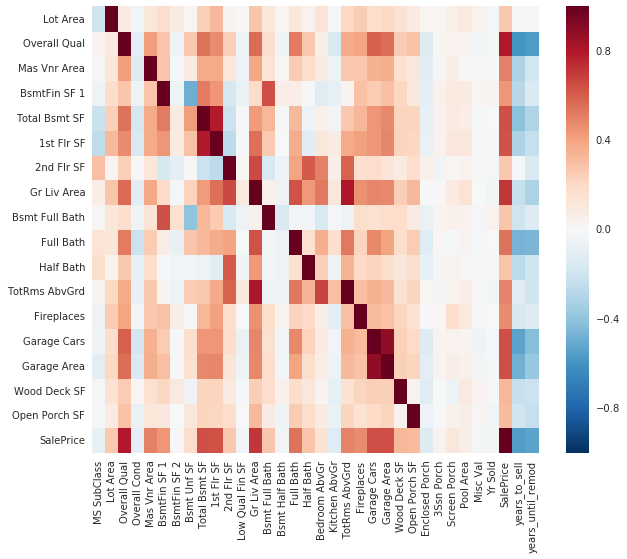

In [8]:
import seaborn as sns
%matplotlib inline
ax = plt.figure(figsize=(10,8))
ax = sns.heatmap(most_corrs)
ax

In [9]:
# drop less correlated features
drop_less_corrs = corrs[corrs['SalePrice'].abs() < 0.25].index
df = df.drop(drop_less_corrs, axis=1)

### Categorical features
From the above procedures, we have selected strongly correlated numerical features. Next, we should deal with the 'object' features. Clarify which features should be keep and then transfrom them to catergorical type.

In [10]:
cat_columns = df.select_dtypes(include=['object']).columns
#categorical_columns contain less than 10 unique values will be kept

drop_columns_1=[]

for col in cat_columns:
    if len(df[col].value_counts()) >10:
        drop_columns_1.append(col)

df = df.drop(drop_columns_1, axis=1)   

In [11]:
#drop_columns_1

['Neighborhood', 'Exterior 1st', 'Exterior 2nd']

In [75]:
# check the remained categorical features, identify of the columns have 
# a few unique values but more than 95% of the values belong to a specific cat

remain_cat_col = df.select_dtypes(include=['object']).columns

check_dict ={}
for col in remain_cat_col:
    check_dict[col] = df[col].value_counts()/len(df)
    

In [80]:
drop_columns_2 =[]

for key, val in check_dict.items():
    if val.iloc[0] > 0.9:
        drop_columns_2.append(key)
        
df = df.drop(drop_columns_2, axis=1)

In [81]:
trans_cat_columns = df.select_dtypes(include=['object']).columns

for col in trans_cat_columns:
    df[col] = df[col].astype('category')

After change the columns' type, we should use the get_dummies() function to make them become dummy variable


Dummy variables are useful because they enable us to use a single regression equation to represent multiple groups. This means that we don’t need to write out separate equation models for each subgroup. The dummy variables act like ‘switches’ that turn various parameters on and off in an equation. Another advantage of a 0,1 dummy-coded variable is that even though it is a nominal-level variable you can treat it statistically like an interval-level variable (if this made no sense to you

## Updated the select_features function

In [82]:
def select_features(df):
    # numeric columns: drop less correlated columns
    numeric_columns = df.select_dtypes(includ=['int','float'])
    corrs = numeric_columns.corr()
    drop_col_1 = corrs[corrs['SalePrice'].abs() <0.25].index
    df = df.drop(drop_col_1, axis=1)
    
    #categorical columns
    category_columns = df.select_dtypes(include=['object']).columns
    drop_col_2 = []
    for col in category_columns:
        if len(df[col].value_counts()) >10: drop_col_2.append(col)
    df = df.drop(drop_col_2, axis=1)
    
    category_columns_new = df.select_dtypes(include=['object']).columns
    check_dict={}
    drop_col_3 = []
    for col in category_columns_new:
        check_dict[col] = df[col].value_counts()/len(df[col])
    for k, val in check_dict.items():
        if val.iloc[0] >0.95:
            drop_col_3.append(k)
    df = df.drop(drop_col_3, axis=1)
    
    cat_ = df.select_dtypes(include=['object']).index
    for col in cat_:
        df[col] = df[col].astype('category')
    
    # get_ dummies
    df = pd.concat([df,pd.get_dummies(df.select_dtypes(include=['object']))], axis=1)
    df = df.drop(cat_, axis=1)
        

    return df



## Train and test model

In [84]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def train_and_test(df,k):
    numerics = df.select_dtypes(includ=['int','float'])
    features = numerics.drop(['SalePrice'], axis=1)
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        lr.fit(df[features], df['SalePrice'])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test['SalePrice'],predictions)
        rmse = np.sqrt(mse)
    
    if k == 1:
        # shuffle the DataFrame rows
        df = df.sample(frac=1)
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train['SalePrice'])
        predictions_1 = lr.predict(test[features])
        mse_1 = mean_squared_error(test[features],predictions_1)
        rmse_1 = np.sqrt(mse_1)
        
        lr.fit(test[features], test['SalePrice'])
        predictions_2 = lr.predict(train[features])
        mse_2 = mean_squared_error(train['SalePrice'], predictions_2)
        rmse_2 = np.sqrt(mse_2)
        
        avg_mse = np.mean(rmse_1,rmse_2)
        return avg_mse
    
    else: 
        kf = KFold(n_splits=k, shuffle = True, random_state=1)
        mse = cross_val_score(lr, df[features], df['SalePrice'],
                              scoring='neg_mean_squared_error',cv=kf)
        rmse = np.sqrt(mse)
        avg_rmse = np.mean(rmse)
        
        return avg_rmse
    
    

# Final Version: Combining the functions together

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


def transform_features(df):
    # drop all columns with over 5% missing values
    all_missing = df.isnull().sum()
    drop_all = all_missing[all_missing > len(df)*0.05]
    df = df.drop(drop_all.index, axis=1)
    
    # drop 'object' columns with one or more missing values
    text_missing = df.select_dtypes(include=['object']).isnull().sum()
    drop_text = text_missing[text_missing > 0]
    df = df.drop(drop_text.index, axis=1)
    
    # fill numeric columns' missing values with most common value
    num_missing = df.select_dtypes(include=['int','float']).isnull().sum()
    num_filling = num_missing[num_missing > 0]
    fill_value = df[num_filling.index].mode().to_dict(orient='records')[0]
    df = df.fillna(fill_value)
    
    #create new features
    df['years_to_sell'] = df['Yr Sold'] - df['Year Built']
    df['years_until_remod'] = years_remod = df['Yr Sold'] - df['Year Remod/Add']  
    df = df.drop([1702, 2180, 2181], axis=0)

    # drop columns aren't useful for machine learning and leak info of final sale
    useless_columns = ["PID", "Order", "Mo Sold", "Sale Condition", 
                       "Sale Type", "Year Built", "Year Remod/Add"]
    df = df.drop(useless_columns, axis=1)
    
    return df

def select_features(df):
    # numeric columns: drop less correlated columns
    numeric_columns = df.select_dtypes(include=['int','float'])
    corrs = numeric_columns.corr()
    drop_col_1 = corrs[corrs['SalePrice'].abs() < 0.25].index
    df = df.drop(drop_col_1, axis=1)
    
    #categorical columns
    category_columns = df.select_dtypes(include=['object']).columns
    drop_col_2 = []
    for col in category_columns:
        if len(df[col].value_counts()) > 10: 
            drop_col_2.append(col)
            
    df = df.drop(drop_col_2, axis=1)
    
    category_columns_new = df.select_dtypes(include=['object']).columns
    check_dict={}
    drop_col_3 = []
    for col in category_columns_new:
        check_dict[col] = df[col].value_counts()/len(df[col])
    for k, val in check_dict.items():
        if val.iloc[0] >0.95:
            drop_col_3.append(k)
    df = df.drop(drop_col_3, axis=1)
    
    cat_ = df.select_dtypes(include=['object']).columns
    for col in cat_:
        df[col] = df[col].astype('category')
    
    # get_ dummies
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
         
    df = df.drop(cat_, axis=1)

    return df

def train_and_test(df, k):
    numerics = df.select_dtypes(include=['int','float','uint8']) # Using dummy variables
    features = numerics.drop(['SalePrice'], axis=1).columns
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        lr.fit(df[features], df['SalePrice'])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test['SalePrice'],predictions)
        rmse = np.sqrt(mse)
    
    if k == 1:
        # shuffle the DataFrame rows
        df = df.sample(frac=1)
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train['SalePrice'])
        predictions_1 = lr.predict(test[features])
        mse_1 = mean_squared_error(test[features],predictions_1)
        rmse_1 = np.sqrt(mse_1)
        
        lr.fit(test[features], test['SalePrice'])
        predictions_2 = lr.predict(train[features])
        mse_2 = mean_squared_error(train['SalePrice'], predictions_2)
        rmse_2 = np.sqrt(mse_2)
        
        avg_mse = np.mean(rmse_1,rmse_2)
        return avg_mse
    
    else: 
        kf = KFold(n_splits=k, shuffle = True, random_state=1)
        mse = cross_val_score(lr, df[features], df['SalePrice'],
                              scoring='neg_mean_squared_error',cv=kf)
        mse = np.abs(mse).mean()
        rmse = np.sqrt(mse)
        
        return rmse
    
    

In [13]:
df = pd.read_csv("AmesHousing.txt", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=3)

In [14]:
rmse

29047.769231157108